# Результаты ЕГЭ в Московских школах

    Цель: на основе открытых данных c data.mos.ru построить дашборд об уровне образовния москвосих школ.

Получаем данные о результатах ЕГЭ с data.mos.ru

In [1]:
from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json

url = 'https://apidata.mos.ru/v1/datasets/2072/rows' 

parameters = {
    'top': 1,
}
headers = {
  'Content-Type': 'application/json',
}

session = Session()
session.headers.update(headers)

try:
  response = session.get(url, params=parameters)
  results_raw = json.loads(response.text)
  #print(data)
except (ConnectionError, Timeout, TooManyRedirects) as e:
  print(e)


Получаем данные о локациях школ с mos.ru

In [2]:
url = 'https://apidata.mos.ru/v1/datasets/2263/features'

try:
  response = session.get(url, params=parameters)
  schools_raw = json.loads(response.text)
  #print(data)
except (ConnectionError, Timeout, TooManyRedirects) as e:
  print(e)


Переводим данные о школах и результатах ЕГЭ dataframe

In [22]:
import pandas as pd
pd.set_option('display.max_columns', None)

schools_raw_df = pd.json_normalize(schools_raw['features'])
results_raw_df = pd.json_normalize(results_raw)

Поулучаем данные о кол-ве учашихся в школах из архива data.mos.ru актуальные на май 2021, они совпадают с периодом сдачи ЕГЭ. 

In [23]:
import re

students_raw_df = pd.read_csv('schools_rating/schools-2021-05-31.csv')
students = pd.DataFrame(students_raw_df['FullName'])
for index, row in students_raw_df.iterrows():
    if type(students_raw_df.loc[index,'NumberofStudentsInOO']) != float:
        students.loc[index, 'students'] = float(re.findall('[0-9]+',  row['NumberofStudentsInOO'])[0])

Извлекаем данные о локации школ и кол-ве студентов

In [24]:
schools = pd.DataFrame(schools_raw_df['properties.Attributes.FullName'])
schools.rename(columns = {'properties.Attributes.FullName':'fullName'}, inplace = True)

In [25]:
for index, row in schools_raw_df.iterrows():
    if row['geometry.type'] == 'MultiPolygon':
        schools.loc[index, 'long'] = row['geometry.coordinates'][0][0][0][0]
        schools.loc[index, 'lat'] = row['geometry.coordinates'][0][0][0][1]
    if row['geometry.type'] == 'Polygon':
        schools.loc[index, 'long'] = row['geometry.coordinates'][0][0][0]
        schools.loc[index, 'lat'] = row['geometry.coordinates'][0][0][1]
    tmp = students.loc[students.FullName == row['properties.Attributes.FullName'], 'students']
    if len(tmp) > 0:
        schools.loc[index, 'students'] = tmp.item()

Объеденяем данные о школах с результатами ЕГЭ

In [26]:
results_raw_df.rename(columns = {'Cells.EDU_NAME':'fullName', 'Cells.YEAR':'year', 'Cells.District': 'district', 'Cells.PASSES_OVER_220':'over_220', 'Cells.PASSER_UNDER_160': 'over_160'}, inplace = True)

In [35]:
results_raw_2021_df = results_raw_df[results_raw_df['year'] == "2020-2021"]
results_2021 = results_raw_2021_df.merge(schools,how='left',on='fullName')

Для 176 из 675 школ с результатами ЕГЭ не нашлось данных в классификаторе учебных заведений. Попытка поиска по номерам школ результатов не дала.

In [36]:
results_2021['students'].isnull().value_counts()

False    499
True     176
Name: students, dtype: int64

Добавляем пропущенные значения, которые можно найти в открытом доступе

In [38]:
row_indexer = results_2021[results_2021["lat"].isnull() & results_2021["students"]].index[0] 
results_2021.loc[row_indexer,'long'] = 37.493497
results_2021.loc[row_indexer,'lat'] = 55.567535

Добавляем рейтинги школ(rate_160 и rate_220). Формула расчета: кол-во сдавших ЕГЭ( на 160 и 220 соответсвенно) деленное на общее кол-во учашихся в средней школе. Здесь мы прибеегаем к допущению о том, что количество учеников в средней школе коррелирует с количеством сдававших экзамен в той же школе. Случаи, когда в среденей школе всего 5 классов(например только 7-11 классы) учесть не получится,таких данных в открытом досупе нет, как и нет данных о точном кол-ве сдававших ЕГЭ по школам.

In [39]:
for index, row in results_2021.iterrows():
    results_2021.loc[index,'district'] = row['district'].replace('район ', '').replace(' район', '')
    if row['students']:
        results_2021.loc[index,'rate_160'] = row['over_160']/row['students']
        results_2021.loc[index,'rate_220'] = row['over_220']/row['students']

Удаляем строки, для которых не удалось найти недостающую информацию

In [41]:
ind_missing = results_2021[results_2021['long'].isnull() | results_2021['students'].isnull()].index
results_cleaned = results_2021.drop(ind_missing, axis=0)

Подготавливаем фрейм с результатами ЕГЭ по районам, индекс нам понадобится для Tablau

In [42]:
districts = pd.DataFrame(results_cleaned.groupby('district', as_index=False)[['rate_160', 'rate_220']].mean())
districts.reset_index(inplace=True)

Создаем фрейм с периметрами районов Москвы

In [43]:
import geopandas as gpd
%matplotlib inline
mo_gdf = gpd.read_file('schools_rating/atd/mo.shp')
mo_gdf_wm = mo_gdf.to_crs({'init' :'epsg:3857'}) #непосредственно преобразование проекции

C:\Users\britva\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Мерджим данные о районах и геоданные.

In [44]:
districts['district_low'] = districts['district'].str.lower()
districts['district_low'] = districts['district_low'].str.replace('ё', 'е')
mo_gdf_wm['name_low'] = mo_gdf_wm['NAME'].str.lower()
mo_gdf_wm['name_low'] = mo_gdf_wm['name_low'].str.replace('ё', 'е')
districts_gdf = districts.merge(mo_gdf_wm[['geometry', 'name_low']], left_on='district_low', right_on='name_low', how='inner')
districts_gdf = gpd.GeoDataFrame(districts_gdf)

In [45]:
districts_gdf

,index,district,rate_160,rate_220,district_low,geometry,name_low
0,0,Академический,0.053528,0.029655,академический,"POLYGON ((4180298.472 7495770.985, 4180305.374...",академический
1,1,Алексеевский,0.044678,0.022164,алексеевский,"POLYGON ((4189507.489 7518137.444, 4189567.289...",алексеевский
2,2,Алтуфьевский,0.035936,0.018151,алтуфьевский,"POLYGON ((4181984.362 7536013.365, 4182546.558...",алтуфьевский
3,3,Арбат,0.051368,0.029375,арбат,"POLYGON ((4182502.576 7509207.346, 4182714.150...",арбат
4,4,Аэропорт,0.057800,0.033795,аэропорт,"POLYGON ((4175706.733 7519908.661, 4175746.507...",аэропорт
...,...,...,...,...,...,...,...
118,118,Южное Тушино,0.040626,0.017544,южное тушино,"POLYGON ((4162438.607 7528064.318, 4162443.950...",южное тушино
119,119,Южнопортовый,0.032585,0.016175,южнопортовый,"POLYGON ((4192368.867 7504992.041, 4192382.982...",южнопортовый
120,120,Якиманка,0.093690,0.064054,якиманка,"POLYGON ((4183120.221 7501731.216, 4183247.448...",якиманка
121,121,Ярославский,0.037830,0.020352,ярославский,"POLYGON ((4192677.812 7526787.544, 4192801.366...",ярославский


Визуализируем данные об рейтинге школ по районам 

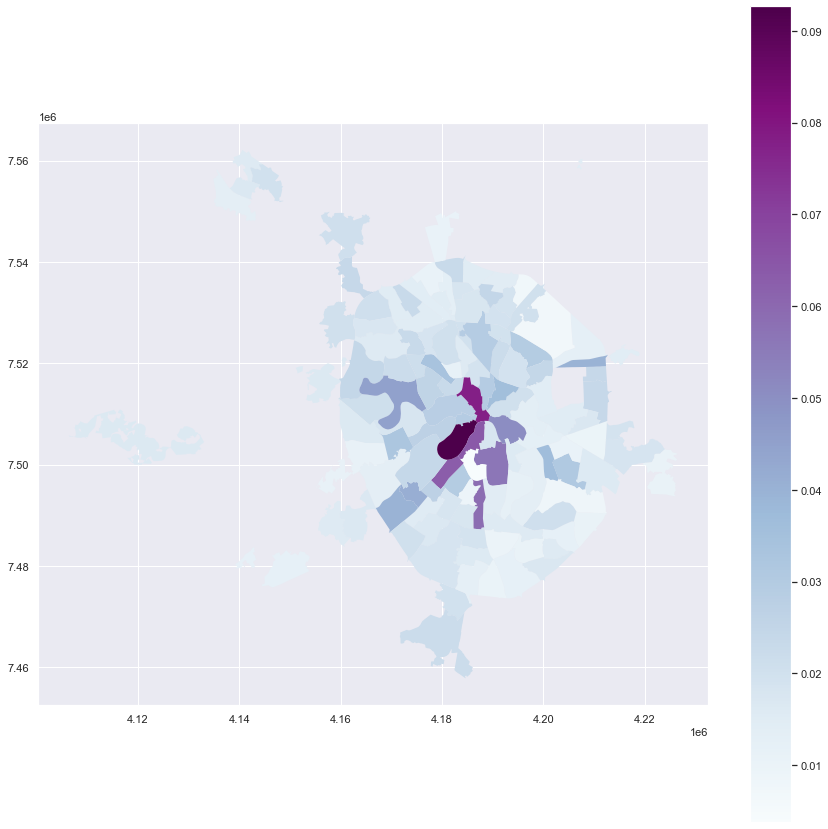

In [160]:
rating_plot = districts_gdf.plot(column = 'rate_220', linewidth=0, cmap='BuPu', legend=True, figsize=[15,15])

Выводим данные о районах в два формата из-за особенностей экспорта в Tableau(shp - не отображает кириллицу)

In [47]:
districts.to_excel("distict_names.xlsx",index=False)

In [48]:
districts_gdf.to_file("districts.shp")

C:\Users\britva\AppData\Local\Temp\ipykernel_12500\2753493840.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  districts_gdf.to_file("districts.shp")


Выводим данные о школах

In [49]:
results_gdf = gpd.GeoDataFrame(results_cleaned, geometry=geopandas.points_from_xy(results_cleaned.long, results_cleaned.lat))

In [ ]:
results_gdf.to_file("schools.geojson", driver='GeoJSON')

Подготовка данных для вывода лидирующих школ по количеству учеников сдавших ЕГЭ более чем на 220 баллов

In [127]:
top5_names = results_raw_df[results_raw_df['year'] == "2020-2021"].sort_values('over_220', ascending=False)['fullName'].head(5)
results_top5_df = pd.DataFrame(results_raw_df[results_raw_df['fullName'].isin(top5_names)])
results_top5_df[['stady_start_year','exam_year']] = results_top5_df.year.str.split('-',expand=True)
results_top5_df['exam_year'] = results_top5_df['exam_year'].astype(str).astype(int)
results_top5_df

,global_id,Number,fullName,Cells.global_id,year,Cells.AdmArea,district,over_220,over_160,stady_start_year,exam_year
396,797988496,397,Федеральное государственное автономное образов...,797988496,2016-2017,Южный административный округ,район Москворечье-Сабурово,221,305,2016,2017
933,880632314,934,Федеральное государственное автономное образов...,880632314,2017-2018,Южный административный округ,район Москворечье-Сабурово,240,317,2017,2018
1089,880632507,1090,Государственное бюджетное общеобразовательное ...,880632507,2017-2018,Центральный административный округ,район Хамовники,316,339,2017,2018
1683,1011905252,1684,Федеральное государственное автономное образов...,1011905252,2018-2019,Южный административный округ,район Москворечье-Сабурово,278,327,2018,2019
1737,1011905309,1738,Федеральное государственное автономное образов...,1011905309,2018-2019,Центральный административный округ,Басманный район,626,682,2018,2019
2095,1011905667,2096,Государственное бюджетное общеобразовательное ...,1011905667,2018-2019,Южный административный округ,Нагорный район,369,406,2018,2019
2117,1011905689,2118,Государственное бюджетное общеобразовательное ...,1011905689,2018-2019,Центральный административный округ,район Хамовники,296,308,2018,2019
2288,1061609100,2289,Федеральное государственное автономное образов...,1061609100,2019-2020,Южный административный округ,район Москворечье-Сабурово,232,307,2019,2020
2822,1061609807,2823,Государственное бюджетное общеобразовательное ...,1061609807,2019-2020,Центральный административный округ,район Хамовники,272,287,2019,2020
2834,1061609821,2835,Федеральное государственное автономное образов...,1061609821,2019-2020,Центральный административный округ,Басманный район,600,633,2019,2020


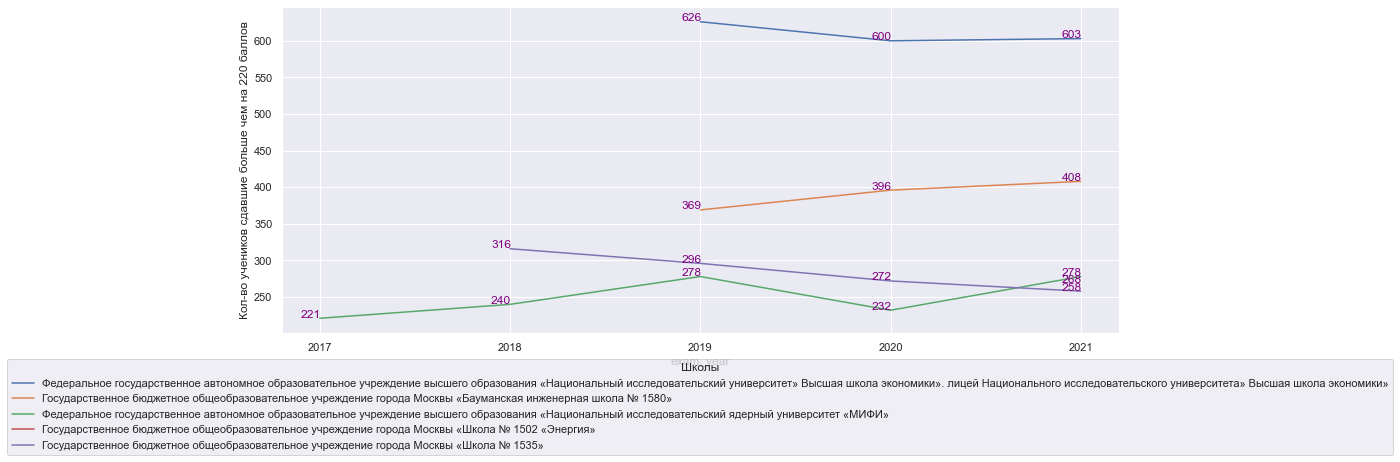

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size (width, height) in inches
fig, ax = plt.subplots(figsize = ( 15 , 6 ))
g = sns.lineplot(ax = ax,x='exam_year',y='over_220',hue='fullName', hue_order=top5_names,data=results_top5_df)
#group data by product and display sales as line chart
# results_top5_df.groupby('fullName')['over_220'].plot(legend=True)
# g=sns.countplot(x=feature, hue='loss', data=data_tr) 
ax.legend(title='Школы',loc='lower center',bbox_to_anchor=(0.5,-0.39))
ax.set_ylabel( "Кол-во учеников сдавшие больше чем на 220 баллов" , size = 12 )
ax.locator_params(integer=True)
# label points on the plot
for x, y in zip(results_top5_df['exam_year'], results_top5_df['over_220']):
 # the position of the data label relative to the data point can be adjusted by adding/subtracting a value from the x &/ y coordinates
 plt.text(x = x-0.1, # x-coordinate position of data label
 y = y+1, # y-coordinate position of data label, adjusted to be 150 below the data point
 s = '{:.0f}'.format(y), # data label, formatted to ignore decimals
 color = 'purple') # set colour of line

## Выводы:
 1. Лицей при ВШЭ 3 года подряд лидирует по кол-ву школьников сдавших ЕГЭ больше чем на 220 баллов
 2. Школьники в ЦАО в среднем здают ЕГЭ лучше, чем школьники в других районах Москвы
 3. Открытые данные об учебных заведениях Москвы плохо стыкуются между собой, 176 из 675 школ сдаваших ЕГЭ не найдены в классификаторе учебных заведений Москвы.

Интерактинвая карта [Tableau Public](https://public.tableau.com/app/profile/boris3594/viz/moscow_shools/Schools_rate)